In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
# Load from local source as a prototype
target_table = "bdp_ap_it.music_service_raw"
spark.sql(f"refresh table {target_table}")
df = spark.sql(f"select * from {target_table}")

In [3]:
df.limit(5).toPandas()

,ts,userId,sessionId,page,itemInSession,auth,method,status,level,location,userAgent,lastName,firstName,registration,gender,artist,song,length,part_date
0,1538352117000,30,29,NextSong,50,Logged In,PUT,200,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1538173362000,M,Martha Tilston,Rockpools,277.89016,20181001
1,1538352180000,9,8,NextSong,79,Logged In,PUT,200,free,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1538331630000,M,Five Iron Frenzy,Canada,236.09424,20181001
2,1538352394000,30,29,NextSong,51,Logged In,PUT,200,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1538173362000,M,Adam Lambert,Time For Miracles,282.82730,20181001
3,1538352416000,9,8,NextSong,80,Logged In,PUT,200,free,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1538331630000,M,Enigma,Knocking On Forbidden Doors,262.71302,20181001
4,1538352676000,30,29,NextSong,52,Logged In,PUT,200,paid,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1538173362000,M,Daft Punk,Harder Better Faster Stronger,223.60771,20181001


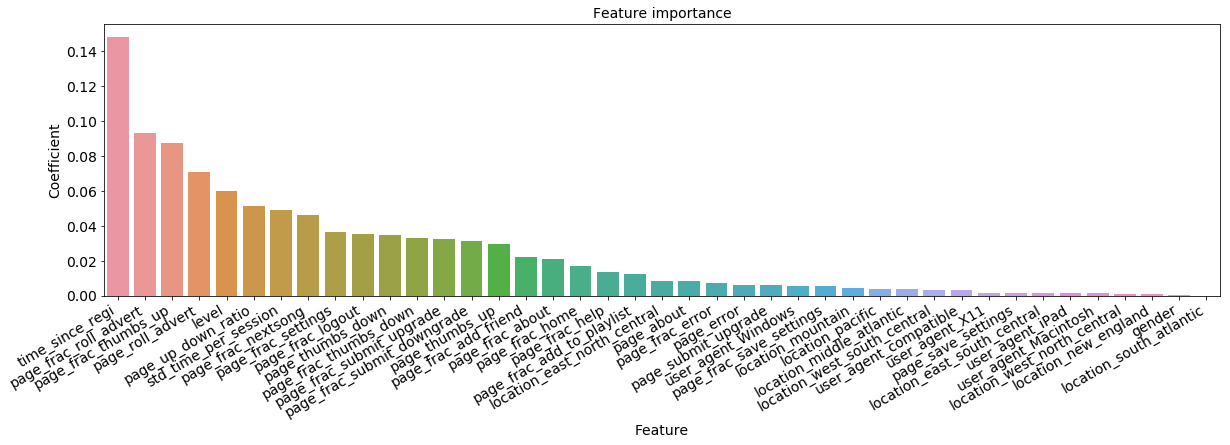

In [9]:
feature_name = ['gender', 'level', 'location_east_north_central', 'location_east_south_central', 
                'location_middle_atlantic', 'location_mountain', 'location_new_england', 
                'location_pacific', 'location_south_atlantic', 'location_west_north_central', 
                'location_west_south_central', 'page_about', 'page_error', 'page_frac_about', 
                'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 
                'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 
                'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 
                'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 
                'page_frac_thumbs_up', 'page_roll_advert', 'page_save_settings', 'page_submit_upgrade', 
                'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'std_time_per_session', 
                'time_since_regi', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 
                'user_agent_compatible', 'user_agent_iPad']
feature_coef = [0.00011934404163344184, 0.05998992893742172, 0.008263963868020228, 0.001328165045186746, 
                0.0035519853475360374, 0.004309741947264267, 0.001084376660471054, 0.0038959856128285876, 
                1.3811217349589163e-05, 0.001090828310055611, 0.0031641238693605298, 0.008261258669485409, 
                0.0062082640170331915, 0.021131340399483445, 0.02212706103481023, 0.012157034186842072, 
                0.007057782594066632, 0.013796412932499058, 0.017201910440687255, 0.035245468449416804, 
                0.04631330659837105, 0.09301677879058716, 0.005506712349074255, 0.03626064285478916, 
                0.031432728028639376, 0.032644767721278764, 0.03317911992112143, 0.0874924512521663, 
                0.0708893108940275, 0.0015931929358134957, 0.006169492560247412, 0.03491112810121312, 
                0.02964269012298696, 0.051134167453994905, 0.04882327310247028, 0.1482270705319209, 
                0.001237402310487522, 0.005632780031749038, 0.0016246803242076773, 0.003002408125387458, 
                0.0012671084080145244]

feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);